In [1]:
import os
import time
import h5py
import math
import pickle
import numpy as np
import pandas as pd
import cv2
import threading
import queue
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from tensorflow.python.client import device_lib

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_PATH = '/kaggle/dev/carvana-image-masking-challenge-data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

# Constants
HEIGHT_ORIG = 1280
WIDTH_ORIG = 1918
CHANNELS_ORIG = 3

SEED_VAL = 42

HEIGHT = 1024
WIDTH = 1024
CHANNELS = 3
new_shape = (HEIGHT, WIDTH, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

In [3]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)

metadata_df = pd.read_csv(METADATA_PATH)
print('metadata_df.shape', metadata_df.shape)

train_masks_df.shape (5088, 2)
metadata_df.shape (6572, 6)


In [4]:
np.random.seed(SEED_VAL)
choice = np.random.choice(len(train_masks_df), 20)
train_masks_df.iloc[choice,:]

,img,rle_mask
860,2af7c265531e_13.jpg,677880 77 679780 115 681683 144 683589 168 685...
3772,c2fd64144e97_13.jpg,430227 1 432146 1 434064 2 435983 2 437902 2 4...
3092,9274d0b3caa8_05.jpg,889118 93 891000 171 892898 213 894801 242 896...
466,189a2a32a615_03.jpg,586204 2 588121 3 590039 2 591957 2 593874 3 5...
4426,de74550a306a_11.jpg,610573 1 612490 4 614409 4 616327 5 618246 5 6...
3444,ad5a6a058944_05.jpg,921589 49 923483 98 925386 129 927292 155 9292...
3171,9ab2a45de8c7_04.jpg,755004 6 756915 20 758829 25 760745 28 762661 ...
2919,888e04d96663_08.jpg,626336 1 628254 1 630171 1 632089 1 634006 2 6...
130,0cdf5b5d0ce1_03.jpg,616821 1 618737 3 620655 3 622572 4 624489 5 6...
1685,4dc8a7fe7c02_06.jpg,544187 1 546103 3 548020 3 549937 3 551854 3 5...


In [52]:
# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

def get_img(img_id):
    return mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
       
def get_mask(img_id, num_channels=-1):
    if num_channels!=-1:
        mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"), flatten=True)
        mask[mask > 128] = 1
        if len(mask.shape) == 2:
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        return mask
    else:
        mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
        mask = mask[:,:,0:3]
        return mask

def resize_img(img, new_s = new_shape):
    return transform.resize(img, new_s)

def load_imgs(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".jpg"))
    return img

def gray2rgb(img):
    img = np.squeeze(img)
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

In [6]:
def check_mask(mask_id):
    print("mask id:", mask_id)
    plot_mask(mask_id)
    img = get_img(mask_id)
    mask = get_mask(mask_id, 1)
    masked_img = img * mask
#     print('mask:', mask.shape) 
#     print('img:', img.shape)
#     imgplot = plt.imshow(masked_img)
#     plt.axis('off')
#     plt.show()
    mask = get_mask(mask_id, -1)
    threshold = 127
    imgray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255,0)
    im2, contours, hierachy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    im = cv2.drawContours(imgray, contours, -1, (255,255,255), 3)
    imgplot = plt.imshow(im)
    plt.axis('off')
    plt.show()
    

In [7]:
#check_mask(train_masks_df.iloc[0,0][0:-4])
#check_mask('8d1a6723c458_01')

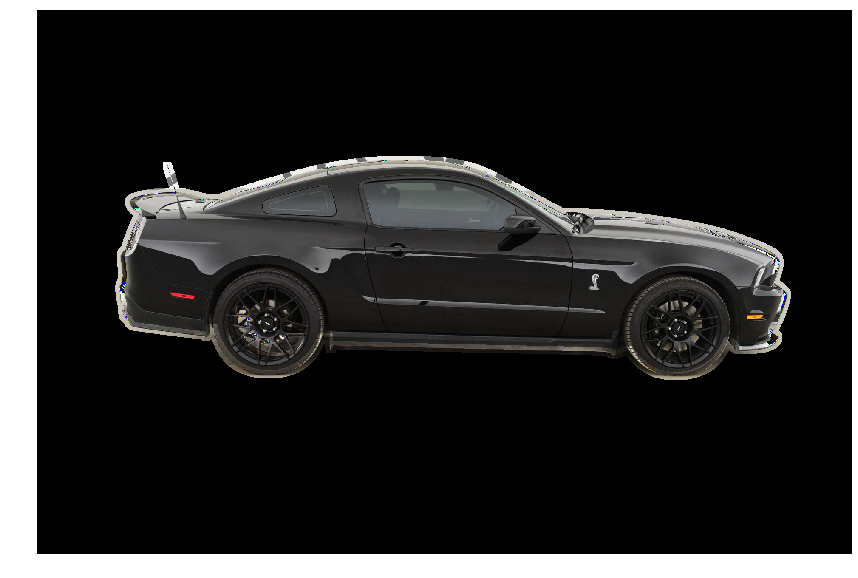

In [125]:


_id = '2af7c265531e_13'

orig_mask = get_mask(_id,1)
orig_mask = np.squeeze(orig_mask)
orig_mask.shape

def get_model():
    inputs = Input(shape=(1280, 1918, 1))
    #averaged_mask = Conv2D(1, (1, 1), padding='same')(inputs)
    averaged_mask = AveragePooling2D(pool_size=(20, 20), strides=1, padding='same')(inputs)
    model = Model(inputs=inputs, outputs=averaged_mask)
    return model
    
model= get_model()
pred_mask = model.predict(np.expand_dims(get_mask(_id,1),0))

border = (pred_mask>0.01) * (pred_mask< 0.99)
border.astype('float64')
border = np.squeeze(border)

border = border + orig_mask
masked_img = img * gray2rgb(border)

plt.figure(figsize=(20,10))
plt.imshow(masked_img)
plt.axis('off')
plt.show()